## 🧠 Experiment Overview — VMD Decomposition on Real MEG Data

### 🎯 Objective
This notebook applies **Variational Mode Decomposition (VMD)** to **real MEG recordings** in order to:
- Decompose each channel into interpretable oscillatory modes.
- Characterize their **spectral**, **statistical**, and **multifractal** properties.
- Identify potential **physiological rhythms** (α, β, γ bands) through clustering and envelope analysis.

The results serve as a bridge between *synthetic benchmark experiments* (`00_simulation_pipeline.ipynb`) and *multivariate extensions* (`02_mvmd_pipeline.ipynb`).

### ⚙️ Dataset
- **Source:** Resting-state MEG recording (`sub-01_ses-01_task-rest_proc-filt_raw.fif`)
- **Channels:** 306 MEG sensors  
- **Sampling frequency:** 250 Hz  
- **Duration:** 300 seconds  

The dataset provides realistic neural dynamics for validating the spectral decomposition behavior of VMD in real conditions.

### 🧩 Processing Pipeline
1. **Signal Exploration:**  
   - Visual inspection of raw MEG data and power spectra.  
   - Initial spectral characterization to select benchmark channels.

2. **VMD Benchmarking:**  
   - Grid search over hyperparameters (`α`, `τ`, `K`) on selected channels.  
   - Evaluation using **MAE** (reconstruction error) and **Spectral Overlap Index (SOI)**.  
   - Selection of optimal parameters per channel.

3. **Full Decomposition:**  
   - Run VMD with optimal parameters on all 306 MEG channels.  
   - Save modes and extracted features.

4. **Clustering And Finding Physiological Bands:**  
   - Compute energy, entropy, spectral peaks, Hjorth parameters, etc.  
   - Cluster modes (KMeans) to reveal distinct **frequency bands** (α, β, γ…).  
   - Validate clusters through correlation and band assignment.

5. **Envelope Correlation & Subgroup Detection:**  
   - Extract mode envelopes to analyze amplitude-coupling structure.  
   - Compute intra-cluster correlation matrices and detect **subgroups** using hierarchical clustering.   

6. **Multifractal Analysis (MFA):**  
   - Apply **wavelet p-leader multifractal analysis** to envelope centroids.  
   - Quantify **scale-invariance** and **temporal complexity** of each physiological band.

### 🔍 Expected Insights
- Evaluate how well **VMD isolates canonical frequency bands** from real MEG data.  
- Assess **inter-mode independence** (via correlation and SOI).  
- Relate **multifractal properties** to physiological rhythms and brain criticality.  


### 📁 Key Outputs
- The results of the parameters benchmark are saves in `../results/real/VMD/benchmark_vmd_first10_channels.csv`
- Decomposed modes saved under `../results/real/VMD/modes....`
- Modes plots saved under `../results/real/VMD/plots`
- Enveloppes modes modes saved under `../results/real/VMD/envelopes`
- Features modes modes saved under `../results/real/VMD/features`
- Features and cluster labels in `../results/real/VMD/features_df_kmeans.csv`
- MFA spectrum and log cumulants summaries  

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
%matplotlib inline

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne 
from sklearn.preprocessing import StandardScaler
from sktime.libs.vmdpy import VMD
from sklearn.cluster import KMeans
from itertools import product
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from pymultifracs.viz import plot_psd
from pymultifracs import mfa, wavelet_analysis
from tqdm import tqdm
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from simulations import compute_features_from_modes_and_save
from decomposition import run_all_decompositions, gridsearch_vmd
from plotting import *
from evaluation import *
from extract_envelopes import *
from mfa_utils import *


In [4]:
# Once you run the experiment for the first time, you can Load results 
# modes_df = pd.read_pickle("../results/real/VMD_modes_df_with_enveloppes_channels.pkl")
# features_df = pd.read_csv("../results/real/features_df_kmeans.csv")

In [5]:
# General Parameters
fs = 250  # Sampling frequency (Hz)
duration = 300.0  # Duration to plot (s)
output_base = "../results/real/VMD"
n_channels_to_process = 306  
n_channels_for_benchmark = 10  # Only for benchmarking
max_points = 1000
methods = ["VMD"]
method = "VMD"
Nmodes = 5

# Prepare parameters grid for the benchmark
alphas = [0, 200, 500, 1000, 5000, 10000, 100000, 1000000]
taus = [0, 0.5, 1]
Nmodes_list = [4, 5, 6]
param_grid = [
    {'Nmodes': k, 'alpha': a, 'tau': t, 'DC': 1, 'init': 1, 'tol': 1e-6}
    for k, a, t in product(Nmodes_list, alphas, taus)
]

## **1. Signal Exploration**:

In [6]:
def load_signal(path):

    raw = mne.io.read_raw_fif(path, preload=True)
    raw_meg = raw.copy().pick('meg')
    data = raw_meg.get_data(return_times=False)
    return raw_meg, data


raw, data_matrix = load_signal("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...


In [7]:
raw

<Raw | sub-01_ses-01_task-rest_proc-filt_raw.fif, 306 x 82500 (330.0 s), ~193.1 MiB, data loaded>

Using matplotlib as 2D backend.


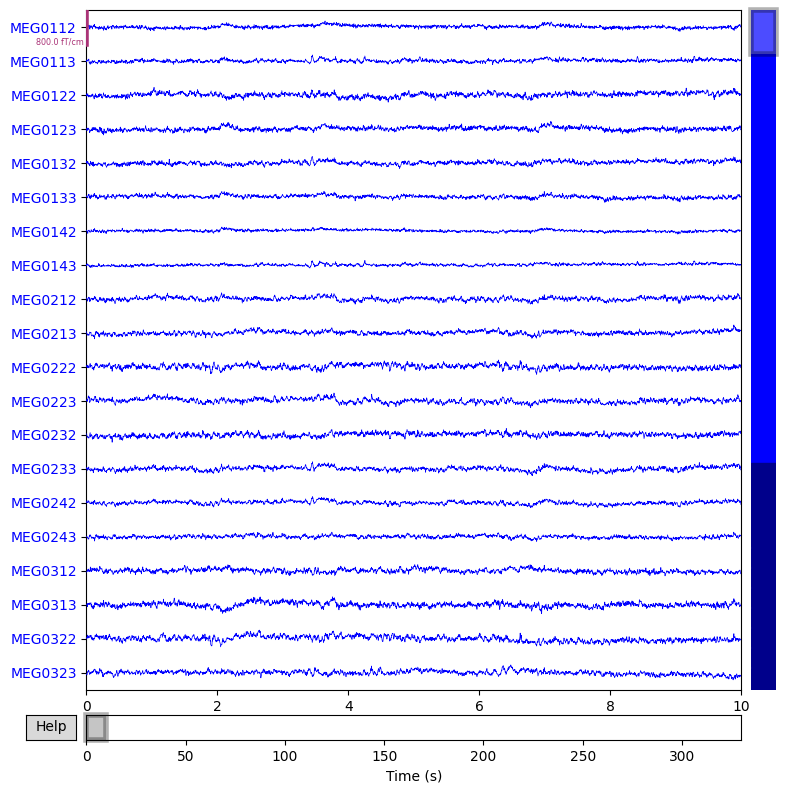

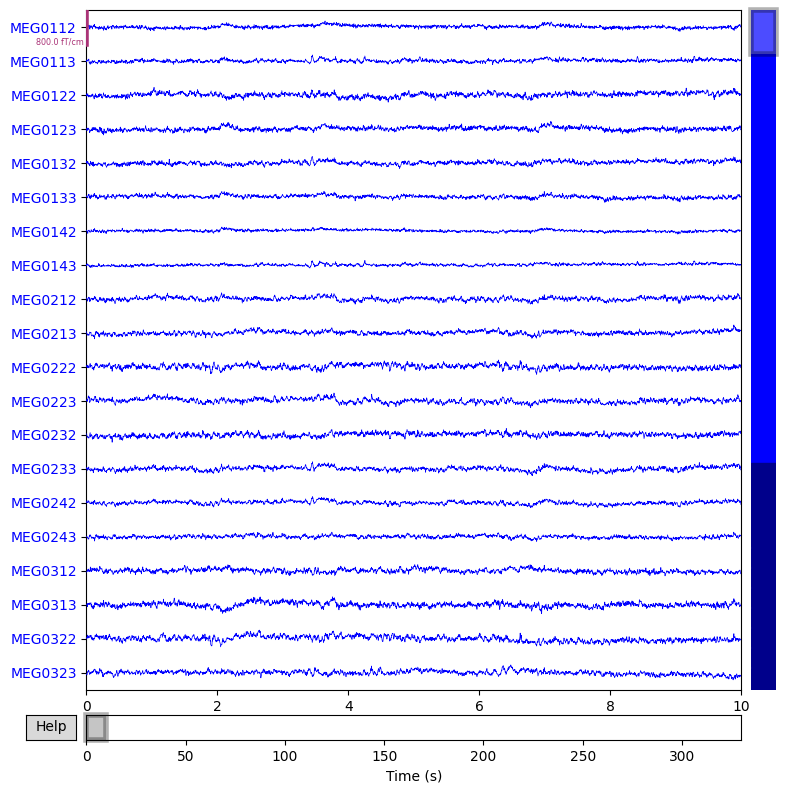

In [8]:
raw.plot()

In [9]:
print(data_matrix.shape)
type(data_matrix)

(306, 82500)


numpy.ndarray

In [10]:
sfreq = raw.info["sfreq"]
sfreq

250.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


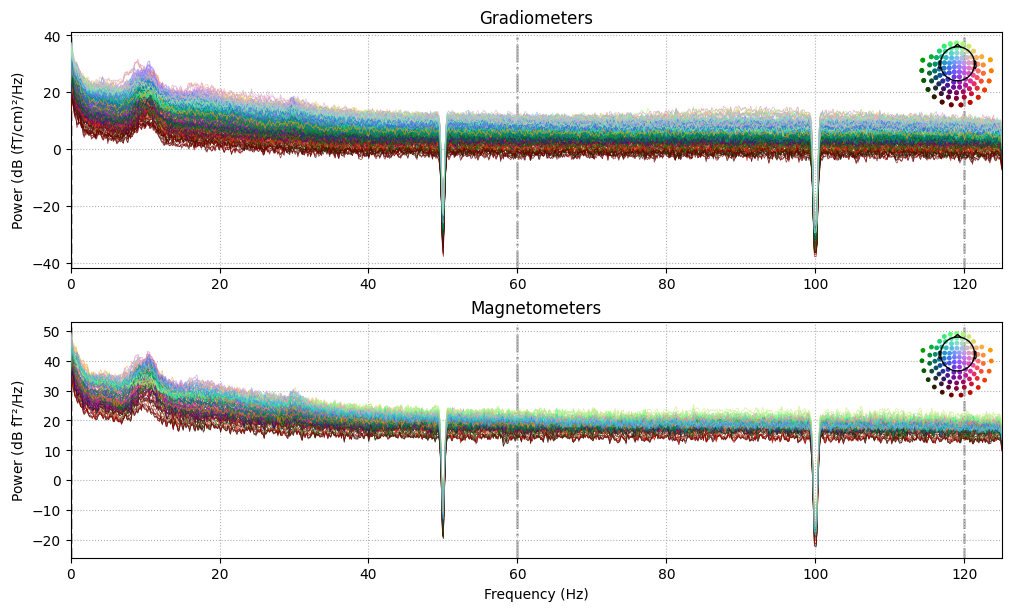

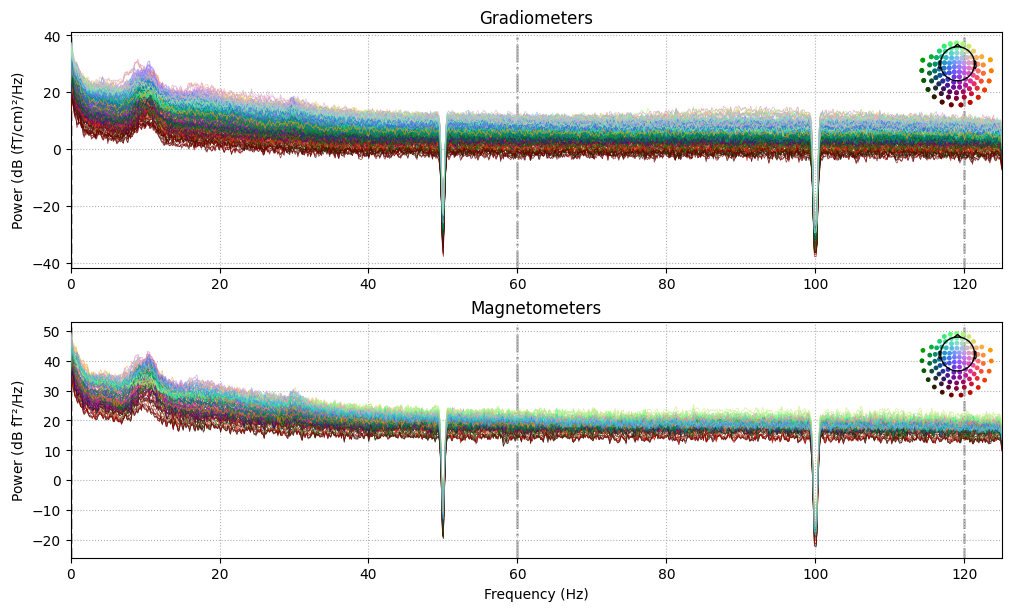

In [11]:
raw.plot_psd()

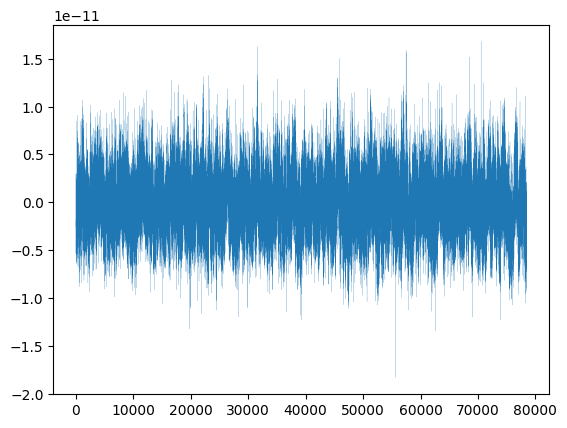

In [12]:
X = data_matrix[2, 2000:-2000]
plt.plot(X, lw=.1)
plt.show()

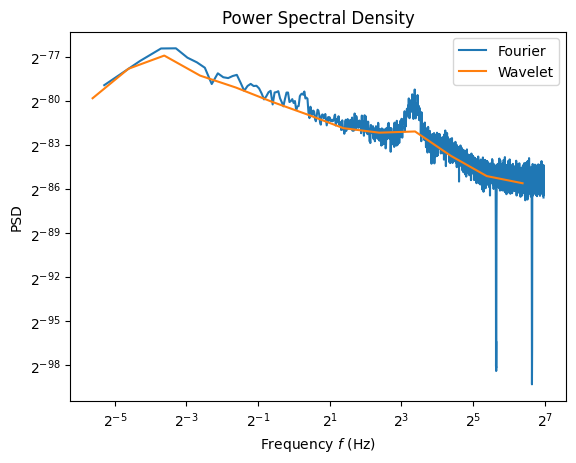

In [13]:
from pymultifracs.viz import plot_psd
plot_psd(X, fs=sfreq)

In [14]:
#modes_df

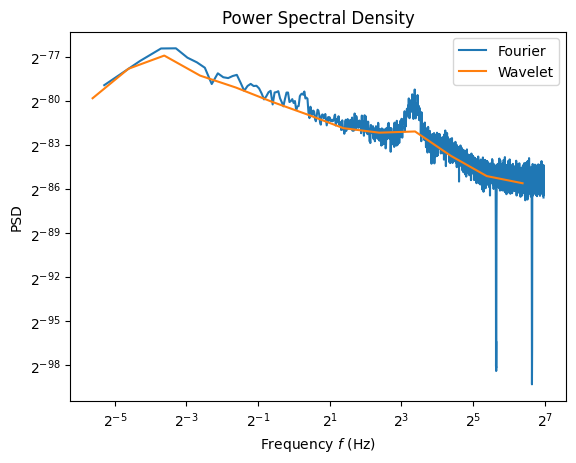

In [15]:
plot_psd(X, fs=250)

In [16]:
WT = wavelet_analysis(X, 'db6').integrate(1)

In [17]:
WT.freq2scale(2.0, sfreq)
WT.scale2freq(9, sfreq)

np.float64(0.35511363636363635)

In [18]:
dwt = mfa(WT, [(6, 11)])

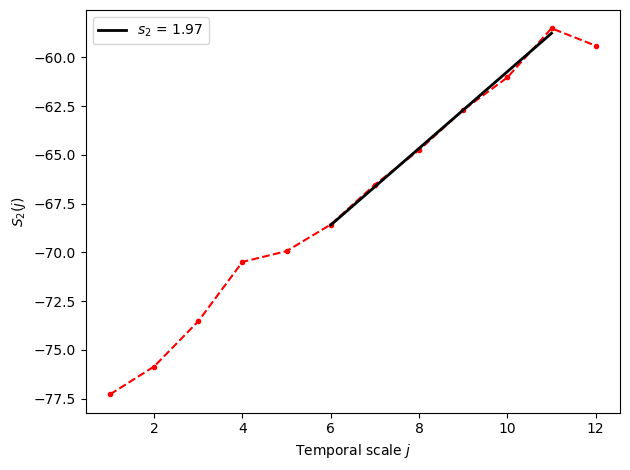

In [19]:
dwt.structure.plot()

In [20]:
H = float(dwt.structure.H.squeeze())

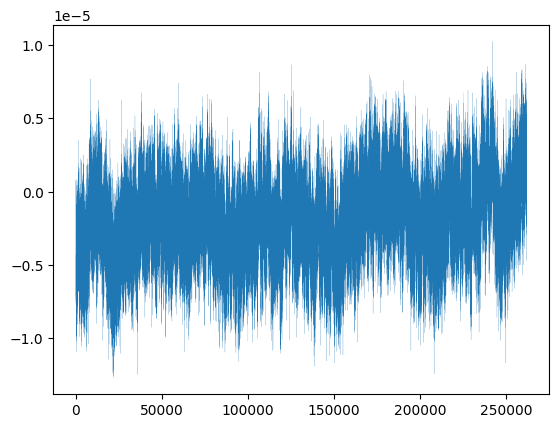

In [21]:
from pymultifracs.simul import fbm
Y = fbm(shape=(2 ** 18), H=H)
plt.plot(np.diff(Y), lw=.1)

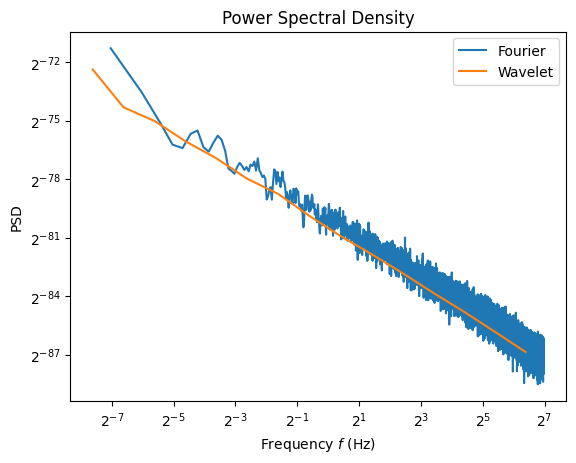

In [22]:
from pymultifracs.viz import plot_psd
plot_psd(np.diff(Y) / np.diff(Y).std() * X.std(), sfreq)


(1.6155871338926322e-27, 1.0587911840678754e-22)

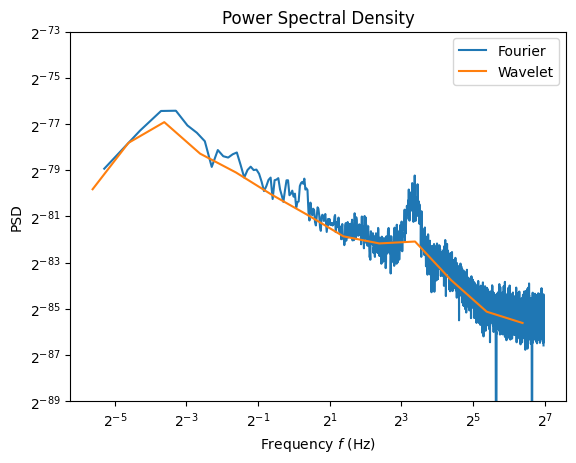

In [23]:
plot_psd(X, sfreq)
plt.ylim(2**-89,2**-73)

## **2. VMD Benchmarking:**  


In [ ]:
all_results = []

# Loop over MEG channels
 
for ch in range(n_channels_for_benchmark):
    sig = data_matrix[ch]
    sig = (sig - np.mean(sig)) / np.std(sig)  # Standardize

    print(f"\nBenchmarking channel {ch}")
    df_results, _ = gridsearch_vmd(sig, fs, param_grid)
    df_results["channel"] = ch
    all_results.append(df_results)

# Save results
df_all = pd.concat(all_results, ignore_index=True)
df_all.to_csv("../results/real/VMD/benchmark_vmd_first10_channels.csv", index=False)
print("✅ Results saved to benchmark_vmd_first10_channels.csv")



✅ Results saved to benchmark_vmd_first10_channels.csv


In [26]:
# Compute a global score as the sum of MAE and mean_soi
df_all["score"] = df_all["MAE"] + df_all["mean_soi"]

# Filter out alpha = 0 (non-valid configuration)
df_all = df_all[df_all["alpha"] != 0]

# Select best configuration (lowest score) for each channel
best_per_channel = (
    df_all.loc[df_all.groupby("channel")["score"].idxmin()]
    .sort_values("channel")
    .reset_index(drop=True)
)

display(best_per_channel)

# Select top 5 best global (alpha, tau) combinations
agg = (
    df_all.groupby(["alpha", "tau"])
    .agg(
        mean_MAE=("MAE", "mean"),
        mean_soi=("mean_soi", "mean"),
        score=("score", "mean"),
        n_channels=("channel", "nunique"),
    )
    .reset_index()
    .sort_values("score")
    .head(5)
)

display(agg)

alpha  tau  K  DC  init       tol       MAE  mean_soi  channel     score
0    200  1.0  6   1     1  0.000001  0.000293  0.019646        0  0.019939
1    200  1.0  6   1     1  0.000001  0.001626  0.020041        1  0.021667
2    200  0.5  6   1     1  0.000001  0.000243  0.020650        2  0.020894
3    500  1.0  6   1     1  0.000001  0.000126  0.021555        3  0.021681
4    500  1.0  6   1     1  0.000001  0.000188  0.021838        4  0.022026
5    200  0.5  6   1     1  0.000001  0.000789  0.022106        5  0.022896
6    200  0.5  6   1     1  0.000001  0.000090  0.021143        6  0.021233

alpha  tau  mean_MAE  mean_soi     score  n_channels
2    200  1.0  0.000479  0.027835  0.028314           7
1    200  0.5  0.009953  0.027720  0.037673           7
5    500  1.0  0.048451  0.027113  0.075564           7
0    200  0.0  0.084178  0.021515  0.105693           7
4    500  0.5  0.083040  0.024068  0.107108           7

## **3. Full Decomposition:** 


### 3.1 Run the Decomposition:

In [27]:
# VMD configuration
max_modes = 5
method = "VMD"

best_vmd_params = {
    'meg': {
        'vmd_alpha': 200,
        'vmd_tau': 0.5,
        'vmd_DC': 1,
        'vmd_init': 0,
        'vmd_tol': 1e-7,
        'Nmodes': max_modes
    },
}

# Create a shared output directory for all modes
modes_output_dir = os.path.join(output_base, "modes")
os.makedirs(modes_output_dir, exist_ok=True)

# Loop over MEG channels to decompose
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :]

    # Standardize the signal
    ch_mean = np.mean(signal)
    ch_std = np.std(signal)

    # Standardize
    signal_scaled = (signal - ch_mean) / ch_std

    name = f"meg_channel_{ch_idx}"

    # Get decomposition parameters
    params = best_vmd_params['meg']

    # Run decomposition
    modes_dict = run_all_decompositions(
        signal_in=signal_scaled,
        methods=methods,
        Fs=fs,
        Nmodes=params['Nmodes'],
        MaxEmdIMF=max_modes,
        MaxVmdModes=max_modes,
        vmd_alpha=params['vmd_alpha'],
        vmd_tau=params['vmd_tau'],
        vmd_DC=params['vmd_DC'],
        vmd_init=params['vmd_init'],
        vmd_tol=params['vmd_tol'],
        return_modes=True
    )



    # 🔁 RESCALE each mode back to the channel’s original scale
    for method, modes in modes_dict.items():
        # modes: array shape (n_modes, n_samples)
        modes_rescaled = modes * ch_std + ch_mean

        out_path = os.path.join(modes_output_dir, f"{name}_{method}_modes.npy")
        np.save(out_path, modes_rescaled)
        print(f"✅ Saved rescaled modes for {method} - {name} to {out_path}")


VMD decomposition done in 8.05 seconds.
✅ Saved rescaled modes for VMD - meg_channel_0 to ../results/real/VMD/modes/meg_channel_0_VMD_modes.npy
VMD decomposition done in 11.13 seconds.
✅ Saved rescaled modes for VMD - meg_channel_1 to ../results/real/VMD/modes/meg_channel_1_VMD_modes.npy
VMD decomposition done in 8.06 seconds.
✅ Saved rescaled modes for VMD - meg_channel_2 to ../results/real/VMD/modes/meg_channel_2_VMD_modes.npy
VMD decomposition done in 6.77 seconds.
✅ Saved rescaled modes for VMD - meg_channel_3 to ../results/real/VMD/modes/meg_channel_3_VMD_modes.npy
VMD decomposition done in 6.13 seconds.
✅ Saved rescaled modes for VMD - meg_channel_4 to ../results/real/VMD/modes/meg_channel_4_VMD_modes.npy
VMD decomposition done in 7.12 seconds.
✅ Saved rescaled modes for VMD - meg_channel_5 to ../results/real/VMD/modes/meg_channel_5_VMD_modes.npy
VMD decomposition done in 5.97 seconds.
✅ Saved rescaled modes for VMD - meg_channel_6 to ../results/real/VMD/modes/meg_channel_6_VMD_m

In [28]:
# Create shared features output directory
features_output_dir = os.path.join(output_base, "features")
os.makedirs(features_output_dir, exist_ok=True)

# Extract features from decomposed modes
for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"

    for method in methods:
        # Path to the modes previously saved in the shared "modes" folder
        modes_path = os.path.join(output_base, "modes", f"{name}_{method}_modes.npy")

        # New path for features saved in shared "features" folder
        features_path = os.path.join(features_output_dir, f"{name}_{method}_features.csv")

        # Compute and save features
        compute_features_from_modes_and_save(modes_path, features_path, fs)
        print(f"Features saved for {method} - {name} to {features_path}")


Features saved to ../results/real/VMD/features/meg_channel_0_VMD_features.csv
Features saved for VMD - meg_channel_0 to ../results/real/VMD/features/meg_channel_0_VMD_features.csv
Features saved to ../results/real/VMD/features/meg_channel_1_VMD_features.csv
Features saved for VMD - meg_channel_1 to ../results/real/VMD/features/meg_channel_1_VMD_features.csv
Features saved to ../results/real/VMD/features/meg_channel_2_VMD_features.csv
Features saved for VMD - meg_channel_2 to ../results/real/VMD/features/meg_channel_2_VMD_features.csv
Features saved to ../results/real/VMD/features/meg_channel_3_VMD_features.csv
Features saved for VMD - meg_channel_3 to ../results/real/VMD/features/meg_channel_3_VMD_features.csv
Features saved to ../results/real/VMD/features/meg_channel_4_VMD_features.csv
Features saved for VMD - meg_channel_4 to ../results/real/VMD/features/meg_channel_4_VMD_features.csv
Features saved to ../results/real/VMD/features/meg_channel_5_VMD_features.csv
Features saved for VMD

In [29]:
# Create a shared plots directory
plots_output_dir = os.path.join(output_base, "plots")
os.makedirs(plots_output_dir, exist_ok=True)

# Plot original signal + decomposed modes
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :] 
    name = f"meg_channel_{ch_idx}"

    for method in methods:
        # Load modes from the shared modes directory
        modes_path = os.path.join(output_base, "modes", f"{name}_{method}_modes.npy")
        if not os.path.exists(modes_path):
            print(f"Modes not found for {method} - {name}, skipping.")
            continue
        
        modes = np.load(modes_path)

        # Plot and save in the shared plots directory
        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=ch_idx,
            output_dir=plots_output_dir,  # <--- Use shared plot folder
            duration=duration,
            max_points=max_points,
            spectrum_method='psd'
        )
        print(f"Plots saved for {method} - {name} to {plots_output_dir}")


Plots saved for VMD - meg_channel_0 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_1 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_2 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_3 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_4 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_5 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_6 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_7 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_8 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_9 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_10 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_11 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_12 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_13 to ../results/real/VMD/plots
Plots saved for VMD - meg_channel_14 to ../results/real/VMD/plots
Plots saved for VMD 

### 3.2 Analyze the Results:

##### Step 1: Compute Correlation Matrix Between Modes (Per Channel)


In [30]:
corr_matrices = []

for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    modes_path = os.path.join(output_base, "modes", f"{name}_VMD_modes.npy")
    # Load shape: (n_modes, n_samples)
    modes = np.load(modes_path)

    # Compute correlation between modes within this channel
    corr = np.corrcoef(modes)  # shape (5, 5)
    corr_matrices.append(corr)

# Stack and average across channels
corr_stack = np.stack(corr_matrices, axis=0)  # shape: (n_channels, 5, 5)
avg_corr_matrix = np.mean(corr_stack, axis=0)  # shape: (5, 5)


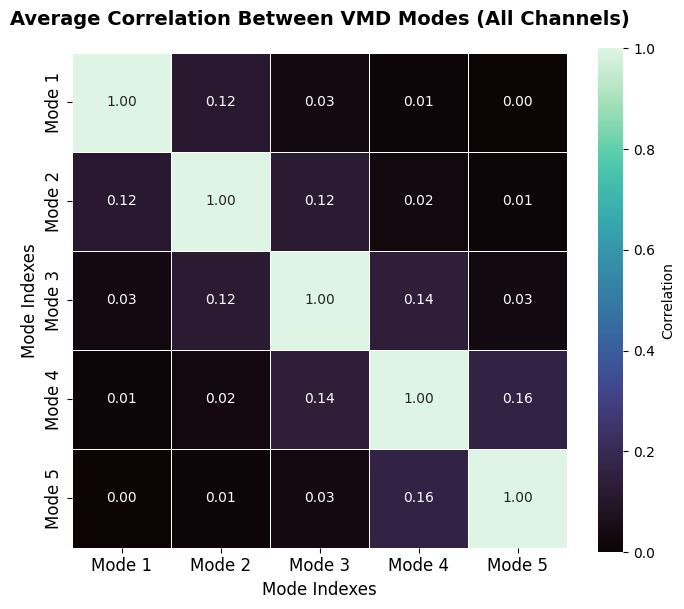

In [31]:
# Plot the average correlation matrix
plot_mode_corr_matrix_vmd(
    corr_matrix=avg_corr_matrix,
    title="Average Correlation Between VMD Modes (All Channels)",
)


##### Step 2: Assign Modes to Physiological Frequency Bands

In [32]:
all_rows = []

# Shared directories
features_dir = os.path.join(output_base, "features")
modes_dir = os.path.join(output_base, "modes")

for ch in range(n_channels_to_process):
    name = f"meg_channel_{ch}"
    
    # Use method name in filenames now (e.g., VMD)
    feat_path = os.path.join(features_dir, f"{name}_{method}_features.csv")
    mode_path = os.path.join(modes_dir, f"{name}_{method}_modes.npy")

    if not os.path.exists(feat_path) or not os.path.exists(mode_path):
        print(f"Missing: {feat_path} or {mode_path}, skipping.")
        continue

    df = pd.read_csv(feat_path)
    modes = np.load(mode_path)
    Nmodes = modes.shape[0]  # Automatically use number of modes

    for mode_idx in range(Nmodes):
        row = [ch, mode_idx]
        features = [
            df[f"{col}{mode_idx}"].iloc[0]
            for col in ["AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", "skew", "kurt", "Hmob", "Hcomp"]
        ]
        band = get_band(features[6])  # Ppeak is at index 6
        all_rows.append(row + features + [band])

# Create final DataFrame
columns = ["channel", "mode", "AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", 
           "skew", "kurt", "Hmob", "Hcomp", "band"]

features_df = pd.DataFrame(all_rows, columns=columns)


In [33]:
features_df["band"].value_counts()

band
Low Gamma        509
High Gamma       322
NotClassified    306
Alpha            305
Beta              88
Name: count, dtype: int64

## **4. Clustering:**  

In [54]:
features_df

channel  mode            AM            BM       ent       pow  \
0           0     0  1.619430e+16  2.429728e+07  3.818828  0.000231   
1           0     1  4.457804e+16  2.854323e+08  5.658255  0.000061   
2           0     2  1.773910e+17  9.454348e+08  7.157653  0.000016   
3           0     3  1.948175e+17  1.800733e+09  7.260703  0.000014   
4           0     4  2.052032e+17  2.465257e+09  7.098242  0.000015   
...       ...   ...           ...           ...       ...       ...   
1525      305     0  9.890172e+14  2.459465e+07  3.973728  0.000209   
1526      305     1  2.496072e+15  2.911765e+08  5.840269  0.000049   
1527      305     2  9.336636e+15  9.687155e+08  7.143784  0.000016   
1528      305     3  1.087823e+16  1.775044e+09  7.268588  0.000014   
1529      305     4  1.119681e+16  2.455662e+09  7.068813  0.000016   

            Cent     Ppeak       Pfreq      skew      kurt      Hmob  \
0       1.369039  0.243514    0.244141 -0.399276  1.123100  0.054765   
1      12.134132  0.064026   10.253906  0.006512  0.358334  0.320878   
2      40.268168  0.013087   37.597656 -0.002142  0.083966  0.981706   
3      76.649285  0.010912   76.904297  0.001041 -0.002774  1.636510   
4     109.202626  0.010984  108.886719  0.000318  0.095243  1.949135   
...          ...       ...         ...       ...       ...       ...   
1525    1.529659  0.227463    0.244141 -0.512417  2.276634  0.057407   
1526   12.386702  0.049080   10.986328  0.058449  0.821177  0.328066   
1527   41.294795  0.012866   42.236328  0.000890  0.026369  1.003138   
1528   75.665607  0.011586   77.636719 -0.014103  0.018117  1.622310   
1529  110.269720  0.011112  108.642578  0.000816  0.014782  1.954452   

          Hcomp           band  kmeans_cluster  
0     11.003011  NotClassified               4  
1      1.336926          Alpha               3  
2      1.073465      Low Gamma               2  
3      1.012601      Low Gamma               5  
4      1.001407     High Gamma               5  
...         ...            ...             ...  
1525  10.562792  NotClassified               4  
1526   1.334098          Alpha               3  
1527   1.067189      Low Gamma               2  
1528   1.013238      Low Gamma               1  
1529   1.001273     High Gamma               1  

[1530 rows x 15 columns]

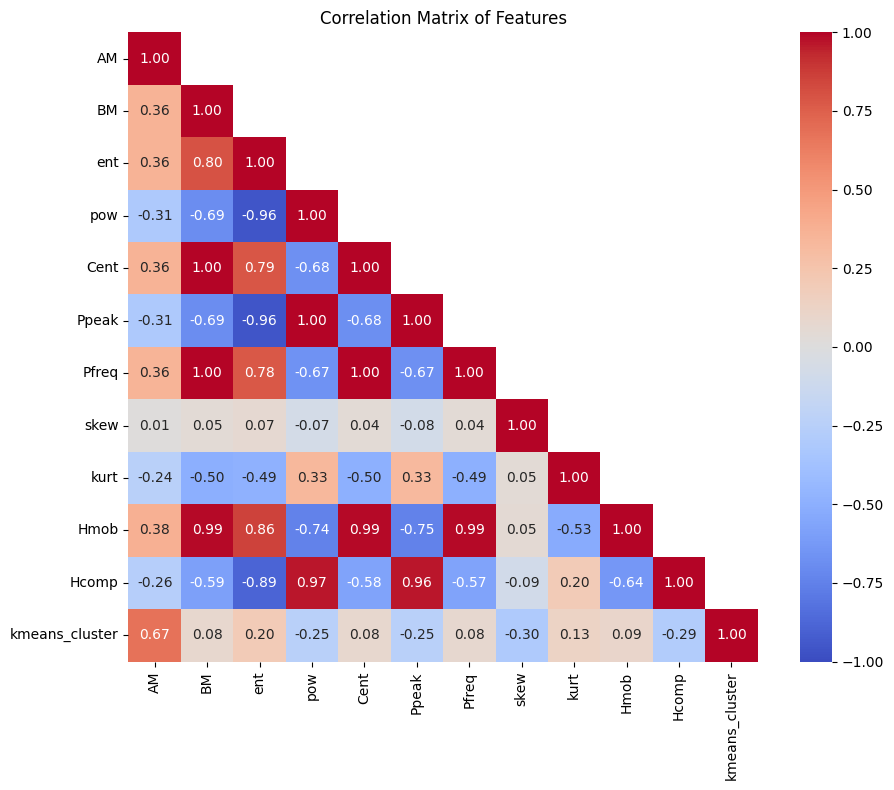

In [56]:
# Visualize Feature Correlation Matrix between the features before clustering

features_to_drop = ["channel", "mode", "band"]
X = features_df.drop(columns=features_to_drop)

corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

##### Step 1: Clustering - Determine Optimal Number of Clusters


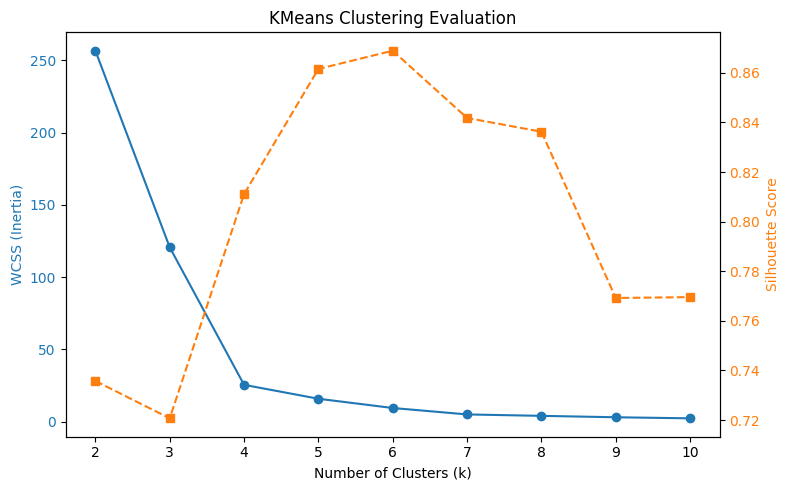

In [ ]:


features_to_keep = ["Pfreq"]
X = features_df[features_to_keep]


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 11)
wcss = []
silhouette_scores = []

for k in k_range:
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(X_scaled)
    wcss.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot WCSS and Silhouette Scores
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.plot(k_range, wcss, marker='o', color=color1)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title("KMeans Clustering Evaluation")

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', color=color2)
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.tight_layout()
plt.show()


In [59]:
# KMeans Clustering
kmeans = KMeans(n_clusters=6,init='k-means++',   random_state=42, n_init=100)
features_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

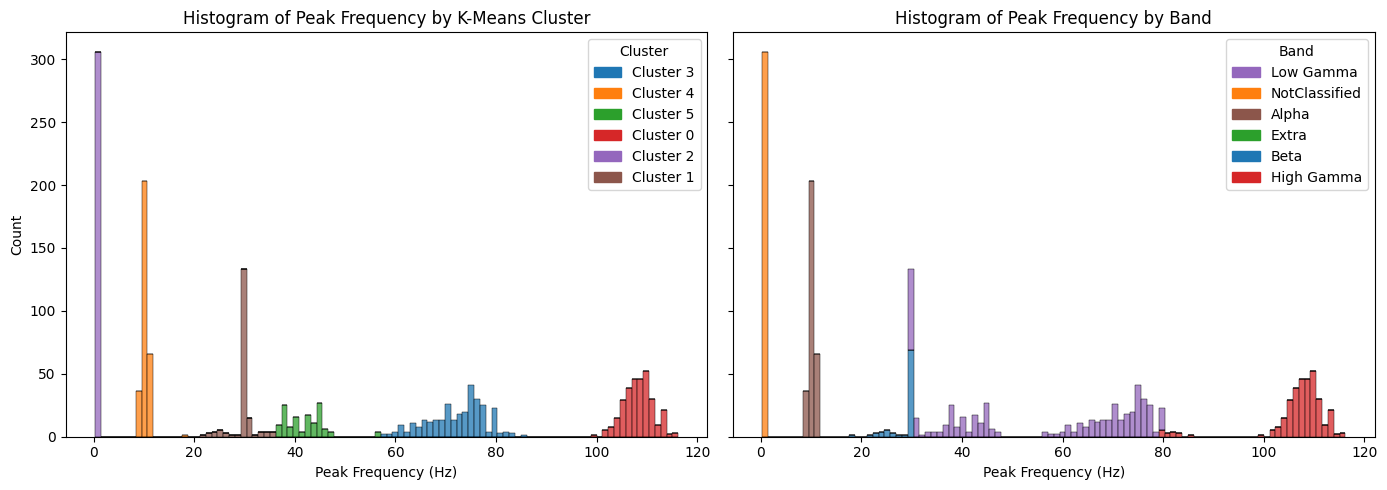

In [61]:

# Prepare color palette
colors = sns.color_palette("tab10", n_colors=6)

# Define custom cluster order (from lowest to highest peak frequency)
cluster_order = [3, 4, 5, 0, 2, 1]

# Map cluster ID to color in this order
cluster_palette = {cluster_id: colors[i] for i, cluster_id in enumerate(cluster_order)}

# Optional: Define band → cluster mapping if known
band_to_cluster = {
    'Low Gamma': 2,
    'NotClassified': 4,
    'Alpha': 1,
    'Extra': 5,  # Replace or rename if needed
    'Beta': 3,
    'High Gamma': 0,
}

# Map bands to same colors as their matching cluster
band_palette = {band: cluster_palette[cluster] for band, cluster in band_to_cluster.items()}

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# ==== (a) Histogram by K-Means Cluster ====
sns.histplot(
    data=features_df,
    x='Pfreq',
    hue='kmeans_cluster',
    hue_order=cluster_order,
    bins=100,
    palette=cluster_palette,
    multiple='stack',
    ax=axes[0]
)
axes[0].set_title("Histogram of Peak Frequency by K-Means Cluster")
axes[0].set_xlabel("Peak Frequency (Hz)")
axes[0].set_ylabel("Count")

# Custom legend for clusters
cluster_legend = [
    Patch(color=cluster_palette[cl], label=f"Cluster {cl}")
    for cl in cluster_order
]
axes[0].legend(handles=cluster_legend, title="Cluster", loc='upper right')

# ==== (b) Histogram by Physiological Band ====
band_order = list(band_palette.keys())  # Preserve your band order

sns.histplot(
    data=features_df,
    x='Pfreq',
    hue='band',
    hue_order=band_order,
    bins=100,
    palette=band_palette,
    multiple='stack',
    ax=axes[1]
)
axes[1].set_title("Histogram of Peak Frequency by Band")
axes[1].set_xlabel("Peak Frequency (Hz)")
axes[1].set_ylabel("Count")

# Custom legend for bands
band_legend = [
    Patch(color=band_palette[band], label=band)
    for band in band_order
]
axes[1].legend(handles=band_legend, title="Band", loc='upper right')

plt.tight_layout()
plt.show()


In [62]:
# Moyenne de fréquence de pic par cluster
avg_freq = features_df.groupby("kmeans_cluster")["Pfreq"].mean().sort_values()
print("Average Peak Frequency per Cluster:")
print(avg_freq)


Average Peak Frequency per Cluster:
kmeans_cluster
2      0.244141
4     10.348052
1     29.738783
5     41.941868
3     72.253499
0    108.251634
Name: Pfreq, dtype: float64


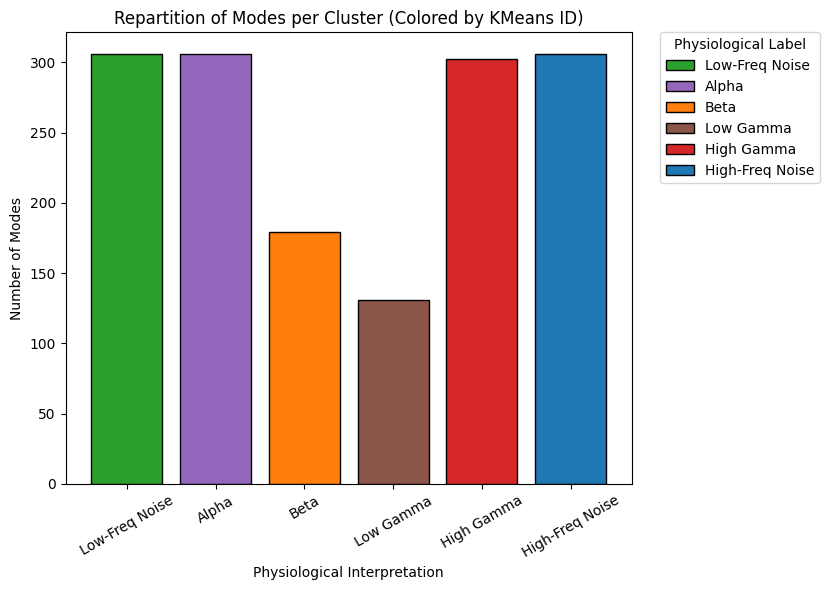

In [63]:
# Frequencies per cluster from earlier results
cluster_peak_freq = {
    2: 0.24,
    4: 10.35,
    1: 29.74,
    5: 41.94,
    3: 72.25,
    0: 108.25
}



# Desired order of bands on x-axis and in legend
band_order = [
    "Low-Freq Noise",
    "Alpha",
    "Beta",
    "Low Gamma",
    "High Gamma",
    "High-Freq Noise"
]

# Generate cluster ID → color mapping using tab10 palette
cluster_ids = sorted(cluster_peak_freq.keys())  # [0, 1, 2, 3, 4, 5]
colors = sns.color_palette("tab10", n_colors=len(cluster_ids))
cluster_color_map = dict(zip(cluster_ids, colors))

# Count number of modes per cluster
counts = features_df["kmeans_cluster"].value_counts().sort_index()

# Store (count, color, cluster_id) for each label
label_info = {}
for cluster_id in counts.index:
    label = label_band(cluster_id,cluster_peak_freq)
    color = cluster_color_map[cluster_id]
    count = counts[cluster_id]
    label_info[label] = (count, color, cluster_id)

# === PLOT ===
plt.figure(figsize=(10, 6))

for label in band_order:
    if label in label_info:
        count, color, cluster_id = label_info[label]
        plt.bar(label, count, color=color, edgecolor='black', label=f"{label}")

# Custom legend (right side)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(
    unique.values(),
    unique.keys(),
    title="Physiological Label",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

# Final formatting
plt.ylabel("Number of Modes")
plt.xlabel("Physiological Interpretation")
plt.title("Repartition of Modes per Cluster (Colored by KMeans ID)")
plt.xticks(rotation=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


In [64]:
# KMeans vs. bands
cont_kmeans = pd.crosstab(features_df["kmeans_cluster"], features_df["band"])
display(cont_kmeans)

band            Alpha  Beta  High Gamma  Low Gamma  NotClassified
kmeans_cluster                                                   
0                   0     0         306          0              0
1                   0    87           0         92              0
2                   0     0           0          0            306
3                   0     0          16        286              0
4                 305     1           0          0              0
5                   0     0           0        131              0

In [65]:
# Save the full features DataFrame with clustering and band labels
output_path = os.path.join(output_base, "features_df_kmeans.csv")
features_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ Saved full features DataFrame with cluster labels to:\n{output_path}")

✅ Saved full features DataFrame with cluster labels to:
../results/real/VMD/features_df_kmeans.csv


##### STEP 2: Analyze Clusters

In [67]:

required_cols = ["channel", "mode", "kmeans_cluster", "band", "signal"]

# Load mode signals from saved .npy files and merge with features_df metadata
modes_df = []
n_channels = features_df["channel"].nunique()

modes_dir = os.path.join(output_base, "modes")

for ch in tqdm(range(n_channels), desc="Loading mode files"):
    name = f"meg_channel_{ch}"
    mode_path = os.path.join(modes_dir, f"{name}_{method}_modes.npy")
    
    if not os.path.exists(mode_path):
        print(f"⚠️ File missing: {mode_path}")
        continue

    modes = np.load(mode_path)
    for mode_idx in range(modes.shape[0]):
        match = features_df[(features_df["channel"] == ch) & (features_df["mode"] == mode_idx)]
        if match.empty:
            print(f"⚠️ No match for channel={ch}, mode={mode_idx}")
            continue
        row = match.iloc[0]
        modes_df.append({
            "channel": ch,
            "mode": mode_idx,
            "kmeans_cluster": row["kmeans_cluster"],
            "band": row["band"],
            "signal": modes[mode_idx]
        })

modes_df = pd.DataFrame(modes_df, columns=required_cols)


Loading mode files: 100%|██████████| 306/306 [00:02<00:00, 103.32it/s]


* Mode 0 -> Cluster 2
* Mode 1 -> Cluster 4
* Mode 2 -> Clusters 1 and 5
* Mode 3 -> Cluster 3 
* Mode 4 -> Cluster 0 

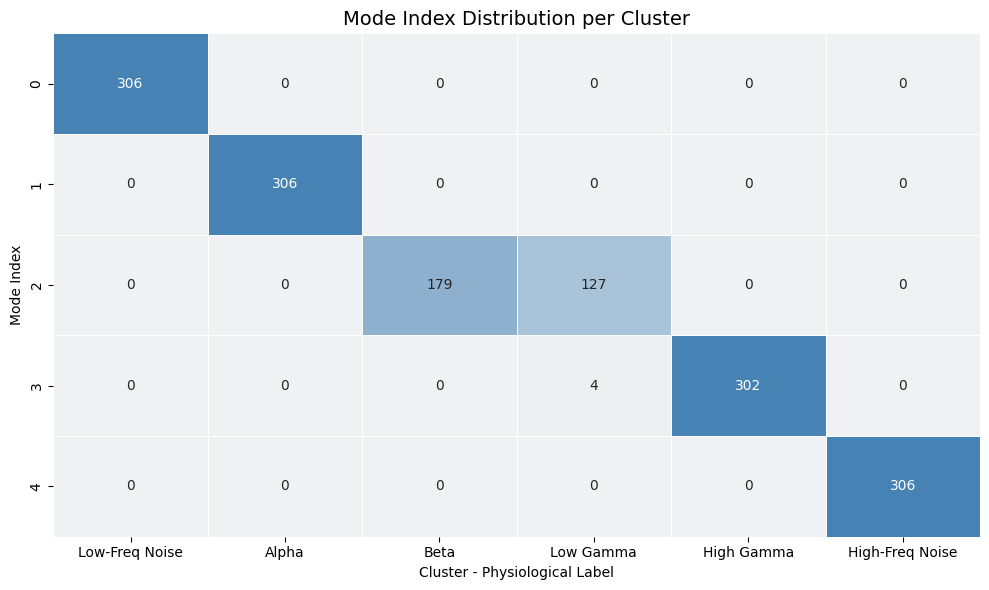

In [68]:
from matplotlib.colors import ListedColormap

# === 1. Cluster ID → Band label map
cluster_band_map = {
    2: "Low-Freq Noise",
    4: "Alpha",
    1: "Beta",
    5: "Low Gamma",
    3: "High Gamma",
    0: "High-Freq Noise"
}

# === 2. Tab10 color palette
cluster_ids = sorted(cluster_band_map.keys())  # [0, 1, 2, 3, 4, 5]
colors = sns.color_palette("tab10", n_colors=len(cluster_ids))
cluster_color_map = dict(zip(cluster_ids, colors))

# === 3. Mode distribution table
mode_distribution = modes_df.groupby(["mode", "kmeans_cluster"]).size().unstack(fill_value=0)

# Rename columns with physiological labels
mode_distribution.columns = [cluster_band_map[cid] for cid in mode_distribution.columns]

# Reorder columns to match frequency order
band_order = [
    "Low-Freq Noise",
    "Alpha",
    "Beta",
    "Low Gamma",
    "High Gamma",
    "High-Freq Noise"
]
mode_distribution = mode_distribution.reindex(columns=band_order)

# === 4. Create a colormap that mimics tab10 but in Blue ambience
# (You can also create a Blue-gradient ambiance for neutral background)
cmap_blues_custom = sns.light_palette("steelblue", as_cmap=True)  # or "royalblue"

# === 5. Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    mode_distribution,
    annot=True,
    fmt="d",
    cmap=cmap_blues_custom,
    cbar = False,
    linewidths=0.5,
    linecolor='white'
)
plt.title("Mode Index Distribution per Cluster", fontsize=14)
plt.xlabel("Cluster - Physiological Label")
plt.ylabel("Mode Index")
plt.tight_layout()
plt.show()


In [69]:
# Group by cluster and compute average peak frequency
avg_pf_per_cluster = (
    features_df
    .groupby("kmeans_cluster")["Pfreq"]
    .mean()
    .sort_values()
)

print("Average Peak Frequency per Cluster (sorted):")
print(avg_pf_per_cluster)

Average Peak Frequency per Cluster (sorted):
kmeans_cluster
2      0.244141
4     10.348052
1     29.738783
5     41.941868
3     72.253499
0    108.251634
Name: Pfreq, dtype: float64


In [70]:
print(features_df.groupby(['kmeans_cluster', 'mode']).size())


kmeans_cluster  mode
0               4       306
1               2       179
2               0       306
3               3       302
4               1       306
5               2       127
                3         4
dtype: int64


###### Compare Power Spectra of Modes Across Clusters

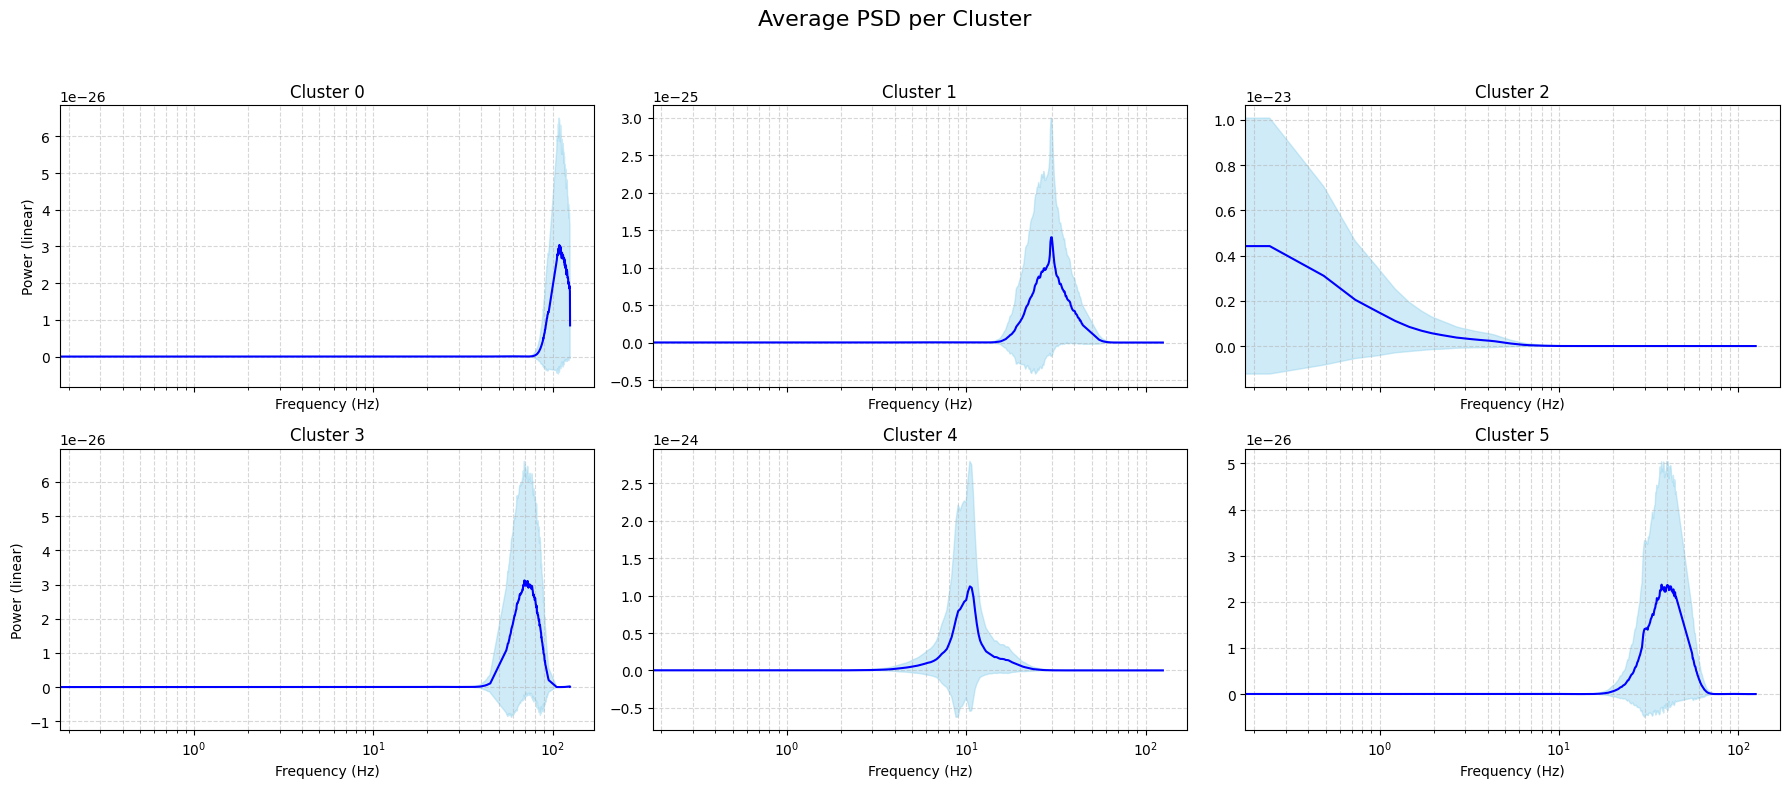

In [71]:
plot_cluster_psds(
    features_df=features_df,
    output_base=output_base,
    method="VMD",
    fs=250,
    cluster_order=[0, 1, 2, 3, 4, 5],
    cluster_labels={
        0: "Cluster 0",
        1: "Cluster 1",
        2: "Cluster 2",
        3: "Cluster 3",
        4: "Cluster 4",
        5: "Cluster 5"
    },
    n_cols=3,
    log_y=False,
    eps=1e-28,
    horizontal=False
)


##### STEP 3: Intra-Cluster Signal Correlation Using Hierarchical Clustering

In [72]:
# Correlation Matrices within Each Cluster
cluster_corrs = {}
cluster_signals = {}

for clust_id in sorted(modes_df["kmeans_cluster"].unique()):
    signals = modes_df[modes_df["kmeans_cluster"] == clust_id]["signal"].tolist()
    n = len(signals)
    corr_mat = np.eye(n)  # Identity matrix (1 on diagonal)

    for i in range(n):
        for j in range(i+1, n):  # upper triangle only
            r, _ = pearsonr(signals[i], signals[j])
            corr_mat[i, j] = r
            corr_mat[j, i] = r

    cluster_corrs[clust_id] = corr_mat
    cluster_signals[clust_id] = signals

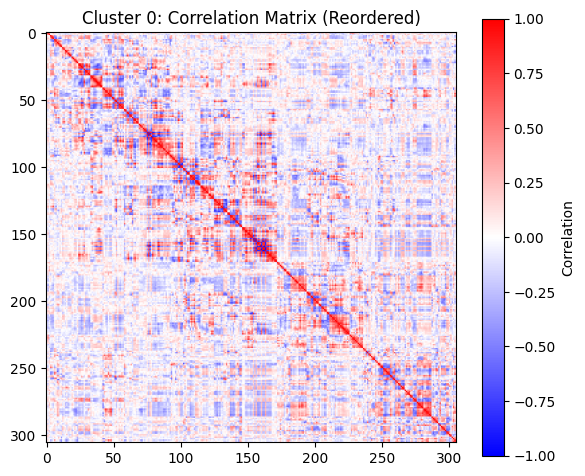

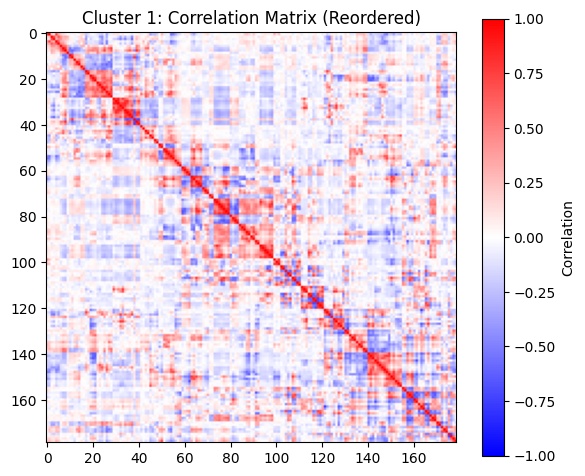

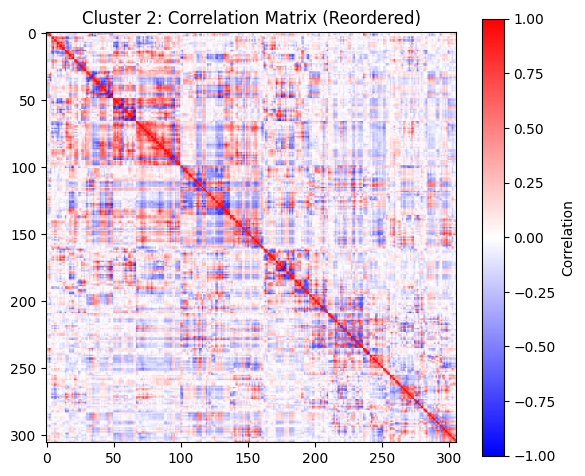

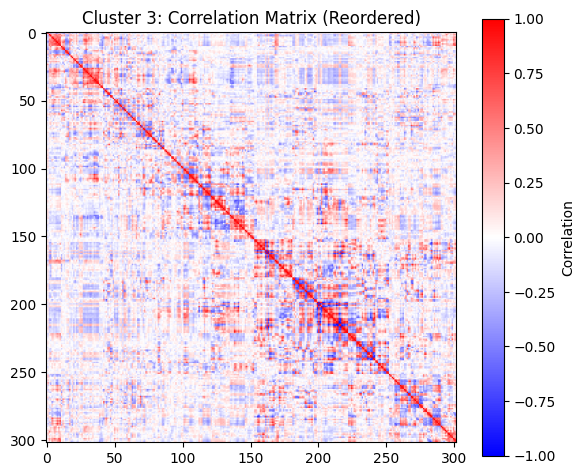

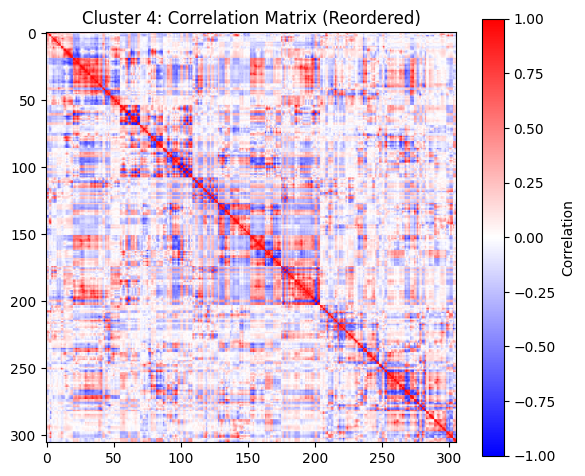

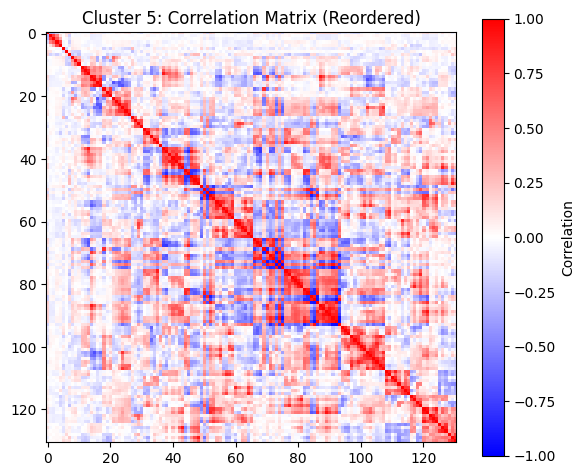

In [73]:
# Reorder Each Matrix Using Hierarchical Clustering
for clust_id, corr_mat in cluster_corrs.items():
    dist = 1 - np.abs(corr_mat)  # convert to distance matrix (range 0–1)
    condensed_dist = squareform(dist)  # convert to condensed format
    Z = linkage(condensed_dist, method='average')
    dendro = dendrogram(Z, no_plot=True)
    order = dendro['leaves']
    reordered_corr = corr_mat[np.ix_(order, order)]

    plt.figure(figsize=(6, 5))
    plt.imshow(reordered_corr, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.title(f"Cluster {clust_id}: Correlation Matrix (Reordered)")
    plt.tight_layout()
    plt.show()

## **5. Enveloppes Extraction:**

In [74]:
extract_envelopes_modes(
    base_dir=output_base,
    method="VMD",
    sfreq=250,
    features_df_path="../results/real/VMD/features_df_kmeans.csv",
    overwrite=True  # Change to True to recompute envelopes even if they exist
)


🔍 Processing meg_channel_0 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_0_VMD_envelopes.npy
🔍 Processing meg_channel_1 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_1_VMD_envelopes.npy
🔍 Processing meg_channel_2 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_2_VMD_envelopes.npy
🔍 Processing meg_channel_3 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_3_VMD_envelopes.npy
🔍 Processing meg_channel_4 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_4_VMD_envelopes.npy
🔍 Processing meg_channel_5 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_5_VMD_envelopes.npy
🔍 Processing meg_channel_6 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_6_VMD_envelopes.npy
🔍 Processing meg_channel_7 with 5 modes...
✅ Saved envelopes to ../results/real/VMD/envelopes/meg_channel_7_VMD_envelo

In [75]:
# Allocate list
envelopes_list = [None] * len(modes_df)

# Load envelope .npy files and match them to modes_df
for ch in tqdm(modes_df["channel"].unique(), desc="Assigning envelopes"):
    envelope_path = os.path.join(
        output_base,
        "envelopes",
        f"meg_channel_{ch}_VMD_envelopes.npy"
    )

    try:
        envelopes = np.load(envelope_path)
        rows = modes_df[modes_df["channel"] == ch]

        for idx, row in rows.iterrows():
            m = row["mode"]
            if m < envelopes.shape[0]:
                envelopes_list[idx] = envelopes[m]
            else:
                print(f"⚠️ Mode {m} out of bounds for channel {ch}")
    except Exception as e:
        print(f"❌ Error for channel {ch}: {e}")


Assigning envelopes: 100%|██████████| 306/306 [00:00<00:00, 314.91it/s]


In [76]:
# Add envelopes column
modes_df["envelope"] = envelopes_list

# Save
output_path = os.path.join(output_base, "modes_df_with_envelopes.pkl")
modes_df.to_pickle(output_path)
print(f"✅ Done. Saved enriched modes_df to '{output_path}'")


✅ Done. Saved enriched modes_df to '../results/real/VMD/modes_df_with_envelopes.pkl'


In [77]:
modes_df

channel  mode  kmeans_cluster           band  \
0           0     0               2  NotClassified   
1           0     1               4          Alpha   
2           0     2               5      Low Gamma   
3           0     3               3      Low Gamma   
4           0     4               0     High Gamma   
...       ...   ...             ...            ...   
1525      305     0               2  NotClassified   
1526      305     1               4          Alpha   
1527      305     2               5      Low Gamma   
1528      305     3               3      Low Gamma   
1529      305     4               0     High Gamma   

                                                 signal  \
0     [-5.017583339462216e-14, -5.261014991693875e-1...   
1     [-3.392763350408755e-14, -3.212532714838822e-1...   
2     [6.952042606264245e-14, -1.8615792759994876e-1...   
3     [9.05414761445411e-15, -2.019241516286839e-14,...   
4     [-6.995578392297886e-15, 1.5562886429827452e-1...   
...                                                 ...   
1525  [-2.107894161523428e-12, -2.090995554381574e-1...   
1526  [1.7310367662048646e-12, 1.6802647746594565e-1...   
1527  [-1.0774508228600035e-12, -6.958313998738576e-...   
1528  [1.0840356766338839e-12, -2.3314166700907294e-...   
1529  [7.734314507313517e-14, -4.133494705701508e-13...   

                                               envelope  
0     [2.8177592443329006e-13, 2.8668228597430954e-1...  
1     [2.7250890927819998e-14, 2.785742239335394e-14...  
2     [1.455957703064348e-14, 1.4221803056003645e-14...  
3     [7.575783469990257e-15, 9.673184792539592e-15,...  
4     [2.1089726569995594e-14, 2.706956615900538e-14...  
...                                                 ...  
1525  [2.647952165276244e-12, 2.6509521500742433e-12...  
1526  [1.1040721620501218e-12, 1.1338227061573817e-1...  
1527  [5.277677441682242e-13, 5.456402457457698e-13,...  
1528  [7.68164658969943e-13, 8.532404586736608e-13, ...  
1529  [2.1713515034180687e-13, 3.042229762667275e-13...  

[1530 rows x 6 columns]

In [78]:
cluster_corrs = {}
cluster_envelope = {}

for clust_id in sorted(modes_df["kmeans_cluster"].unique()):
    envelopes = modes_df[modes_df["kmeans_cluster"] == clust_id]["envelope"].tolist()
    n = len(envelopes)
    corr_mat = np.eye(n)  # initialize with 1s on diagonal

    for i in range(n):
        for j in range(i+1, n):  # only upper triangle
            r, _ = pearsonr(envelopes[i], envelopes[j])
            corr_mat[i, j] = r
            corr_mat[j, i] = r  # force symmetry

    cluster_corrs[clust_id] = corr_mat
    cluster_envelope[clust_id] = envelopes

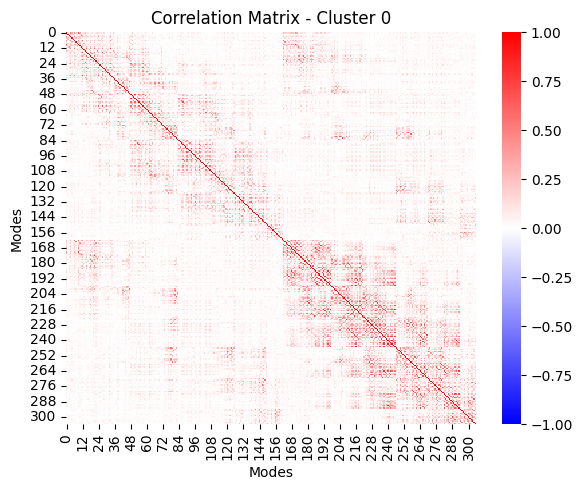

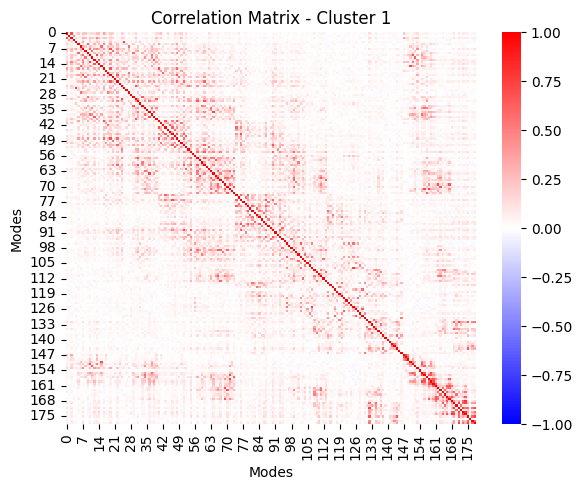

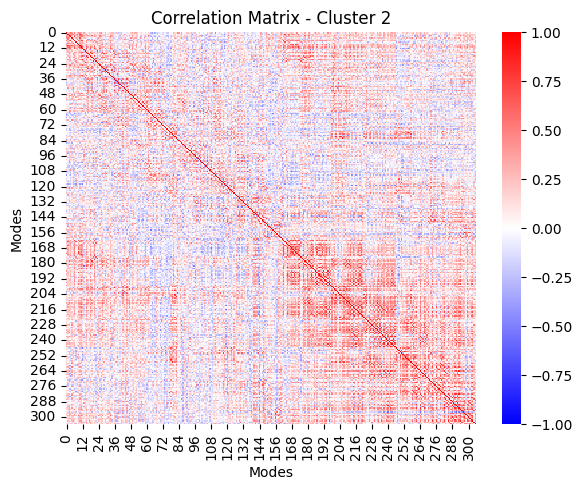

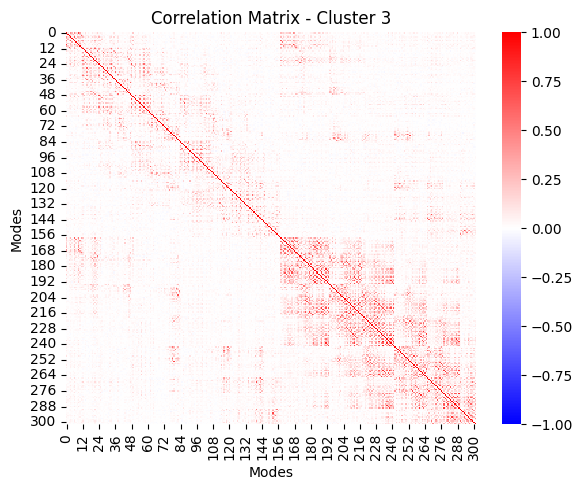

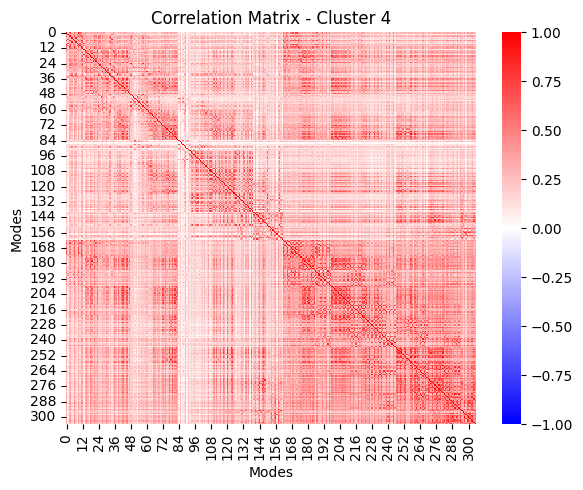

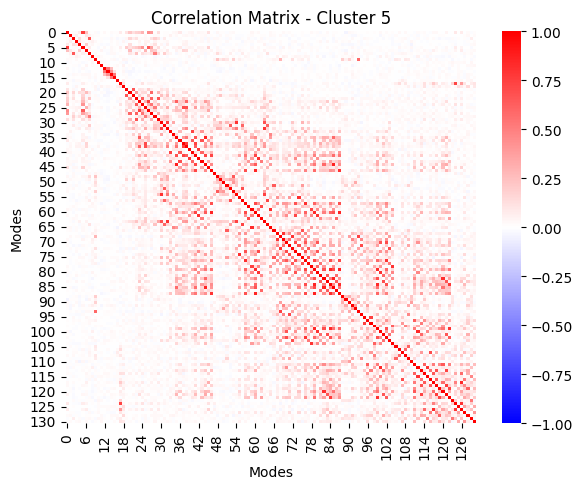

In [79]:
# Sort cluster IDs
cluster_ids = sorted(cluster_corrs.keys())

for clust_id in cluster_ids:
    corr_mat = cluster_corrs[clust_id]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
    corr_mat,
    cmap='bwr',
    center=0,
    cbar=True,
    vmin=-1, 
    vmax=1 )
    plt.title(f"Correlation Matrix - Cluster {clust_id}")
    plt.xlabel("Modes")
    plt.ylabel("Modes")
    plt.tight_layout()
    plt.show()


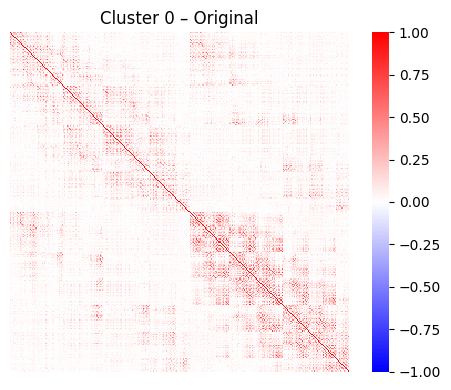

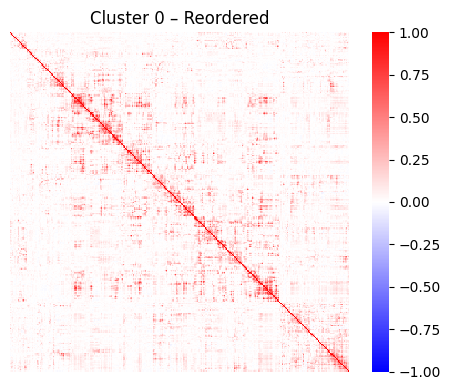

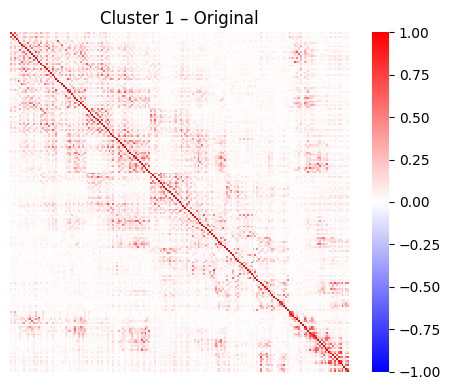

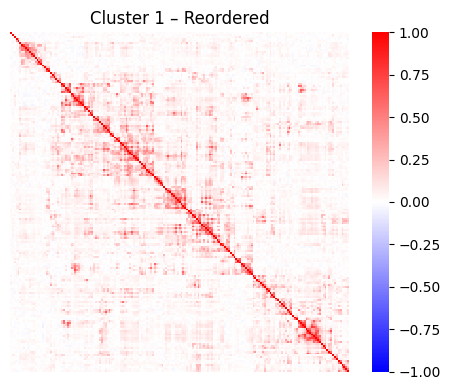

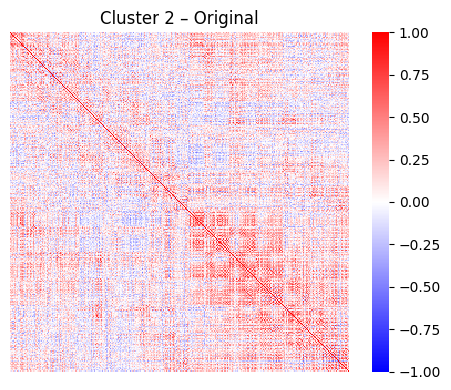

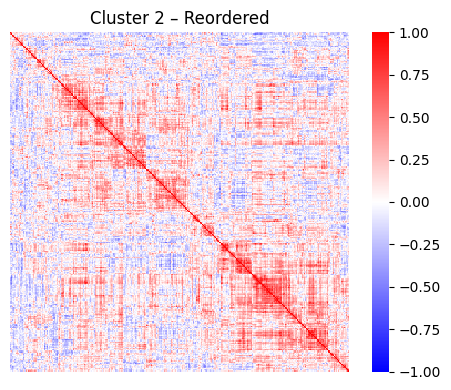

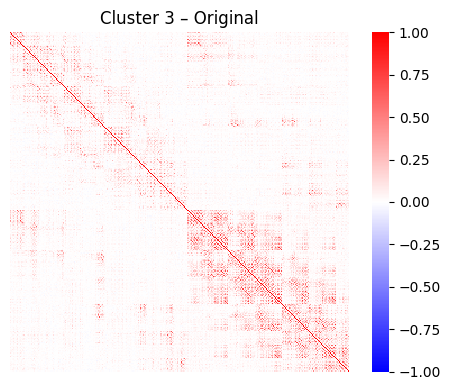

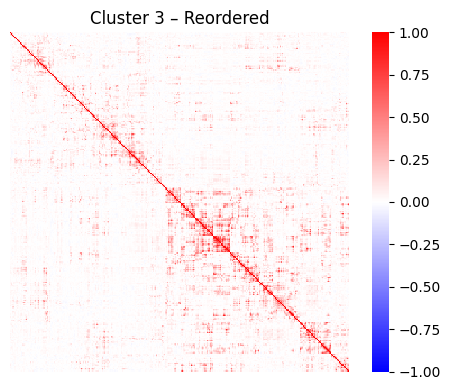

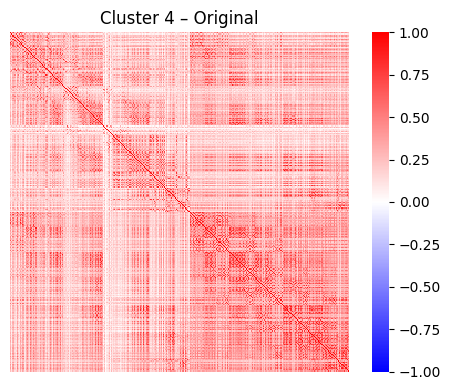

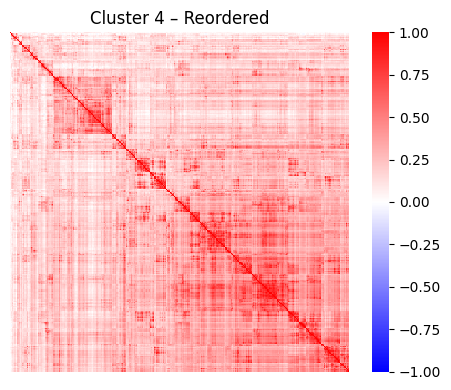

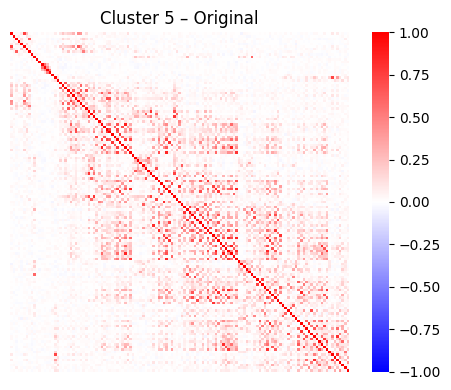

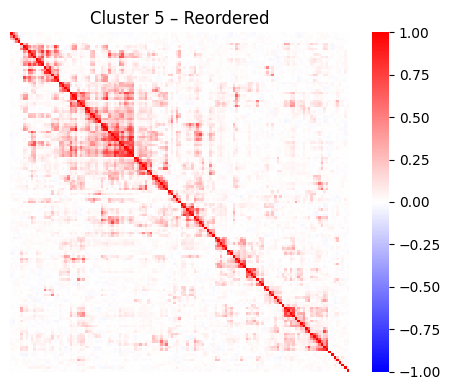

💾 All correlation matrices saved in single files.


In [90]:
corr_dict = {}
reordered_dict = {}
reordered_index_dict = {}

modes_df["subgroup"] = np.nan  # initialize column

for cluster_id in sorted(modes_df["kmeans_cluster"].unique()):
    cluster_df = modes_df[modes_df["kmeans_cluster"] == cluster_id]
    envelopes = cluster_df["envelope"].tolist()
    indices = cluster_df.index.tolist()

    if len(envelopes) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} (only {len(envelopes)} envelope)")
        continue

    # 1. Compute correlation
    corr = compute_envelope_corr(envelopes)

    # 2. Reorder with CAH
    corr_reordered, order = reorder_corr_with_cah(corr)
    reordered_indices = [indices[i] for i in order]

    # 3. Save in dicts
    corr_dict[cluster_id] = corr
    reordered_dict[cluster_id] = corr_reordered
    reordered_index_dict[cluster_id] = reordered_indices

    # 4. Subgroup assignment
    subgroup_labels = assign_subgroups_from_corr(corr)
    for local_i, global_i in enumerate(indices):
        modes_df.loc[global_i, "subgroup"] = subgroup_labels[local_i]

    # 5. Show correlation matrix plots (original and reordered)
    plot_corr(corr, f"Cluster {cluster_id} – Original")
    plot_corr(corr_reordered, f"Cluster {cluster_id} – Reordered")


# Convert keys to strings for saving
corr_dict_str = {str(k): v for k, v in corr_dict.items()}
reordered_dict_str = {str(k): v for k, v in reordered_dict.items()}
reordered_index_dict_str = {str(k): v for k, v in reordered_index_dict.items()}

# Save all in batch
out_dir = "../results/real/VMD"
os.makedirs(out_dir, exist_ok=True)

np.savez(os.path.join(out_dir, "corr_all_clusters.npz"), **corr_dict_str)
np.savez(os.path.join(out_dir, "corr_reordered_all_clusters.npz"), **reordered_dict_str)
np.savez(os.path.join(out_dir, "corr_reordered_indices.npz"), **reordered_index_dict_str)

print("💾 All correlation matrices saved in single files.")

/Users/sabrinebendimerad/Downloads/mfa-internship/scripts/plotting.py:810: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Leave room for colorbar


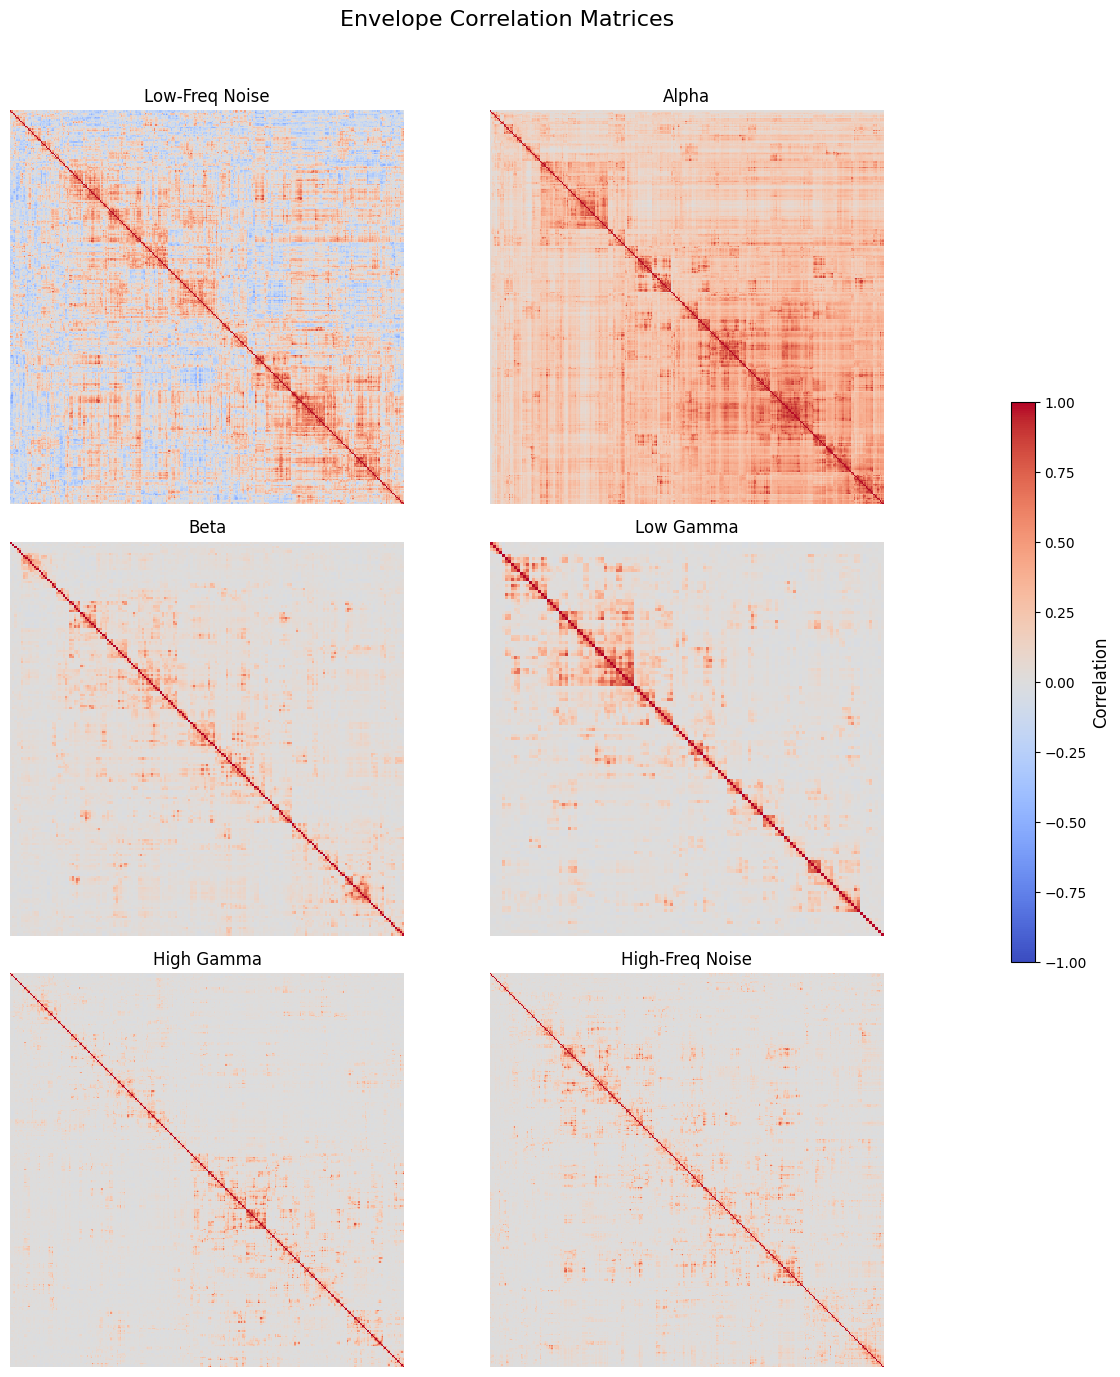

In [94]:
# Load reordered matrices from file
loaded = np.load("../results/real/VMD/corr_reordered_all_clusters.npz", allow_pickle=True)
reordered_dict = {int(k): v for k, v in loaded.items()}

# Plot
plot_reordered_corr_matrices_grid(reordered_dict)


## **6. MFA:**

In [95]:
scaling_ranges = [(6, 12)]
q_vals = np.arange(-3, 6)
summary_records = []
methods = ["VMD"]

In [96]:
modes_df

channel  mode  kmeans_cluster           band  \
0           0     0               2  NotClassified   
1           0     1               4          Alpha   
2           0     2               5      Low Gamma   
3           0     3               3      Low Gamma   
4           0     4               0     High Gamma   
...       ...   ...             ...            ...   
1525      305     0               2  NotClassified   
1526      305     1               4          Alpha   
1527      305     2               5      Low Gamma   
1528      305     3               3      Low Gamma   
1529      305     4               0     High Gamma   

                                                 signal  \
0     [-5.017583339462216e-14, -5.261014991693875e-1...   
1     [-3.392763350408755e-14, -3.212532714838822e-1...   
2     [6.952042606264245e-14, -1.8615792759994876e-1...   
3     [9.05414761445411e-15, -2.019241516286839e-14,...   
4     [-6.995578392297886e-15, 1.5562886429827452e-1...   
...                                                 ...   
1525  [-2.107894161523428e-12, -2.090995554381574e-1...   
1526  [1.7310367662048646e-12, 1.6802647746594565e-1...   
1527  [-1.0774508228600035e-12, -6.958313998738576e-...   
1528  [1.0840356766338839e-12, -2.3314166700907294e-...   
1529  [7.734314507313517e-14, -4.133494705701508e-13...   

                                               envelope  subgroup  
0     [2.8177592443329006e-13, 2.8668228597430954e-1...       0.0  
1     [2.7250890927819998e-14, 2.785742239335394e-14...       0.0  
2     [1.455957703064348e-14, 1.4221803056003645e-14...       0.0  
3     [7.575783469990257e-15, 9.673184792539592e-15,...       0.0  
4     [2.1089726569995594e-14, 2.706956615900538e-14...       0.0  
...                                                 ...       ...  
1525  [2.647952165276244e-12, 2.6509521500742433e-12...     111.0  
1526  [1.1040721620501218e-12, 1.1338227061573817e-1...       0.0  
1527  [5.277677441682242e-13, 5.456402457457698e-13,...      81.0  
1528  [7.68164658969943e-13, 8.532404586736608e-13, ...     226.0  
1529  [2.1713515034180687e-13, 3.042229762667275e-13...     230.0  

[1530 rows x 7 columns]


📊 Processing kmeans_cluster = 0
❌ MFA failed for High-Freq Noise: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [-1.141240e-15],
       ...,
       [-2.486436e-15],
       [ 1.943368e-15],
       [          nan]])

📊 Processing kmeans_cluster = 1
❌ MFA failed for Beta: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [-8.613629e-16],
       ...,
       [ 3.191394e-16],
       [-4.154219e-16],
       [          nan]])

📊 Processing kmeans_cluster = 2


<Figure size 800x400 with 0 Axes>

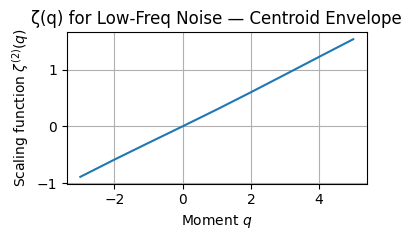

<Figure size 800x400 with 0 Axes>

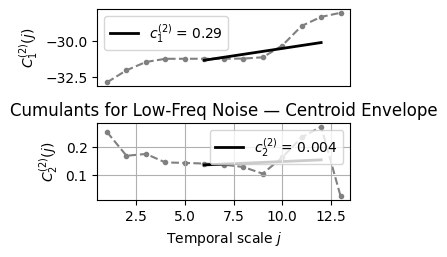

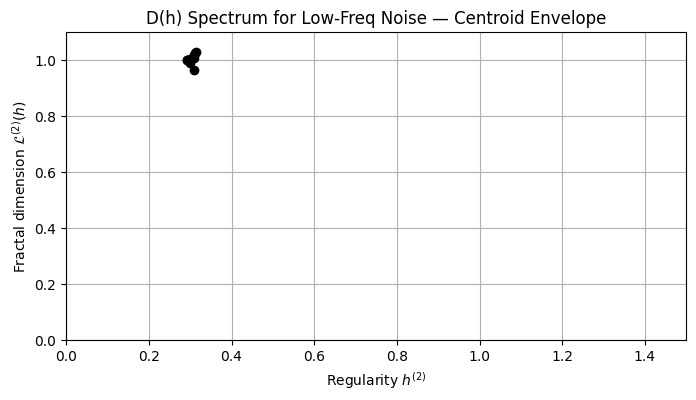


📊 Processing kmeans_cluster = 3
❌ MFA failed for High Gamma: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [-5.376473e-16],
       ...,
       [-3.098204e-16],
       [ 1.783716e-15],
       [          nan]])

📊 Processing kmeans_cluster = 4


<Figure size 800x400 with 0 Axes>

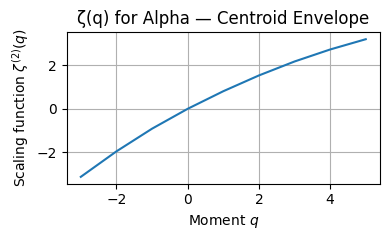

<Figure size 800x400 with 0 Axes>

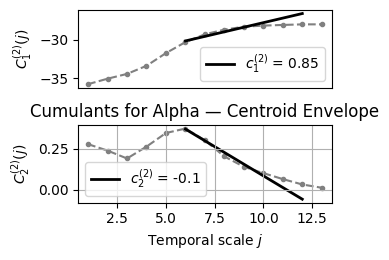

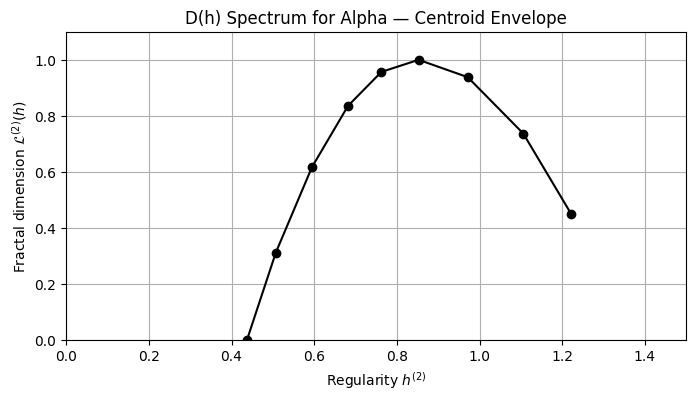


📊 Processing kmeans_cluster = 5
❌ MFA failed for Low Gamma: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

array([[          nan],
       [          nan],
       [-2.722947e-16],
       ...,
       [-2.341921e-15],
       [ 8.557148e-16],
       [          nan]])


In [97]:
summary_df = mfa_on_envelope_centroids(modes_df,scaling_ranges,q_vals,output_base)
